<a href="https://colab.research.google.com/github/RealYarik/ard/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this task, we will load and preprocess X-ray data from dataset .We will then build a CNN leveraging transfer learning from a VGG19 for model. The goal is to predict a diagnosis of COVID-19.**


# Libraries 

In [73]:
import sys
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Creat the Dataset



In [3]:
DATA_DIR = 'covid-chestxray-dataset'
NORMAL_DIR = 'chest_xray'

if DATA_DIR not in os.listdir():
    !git clone https://github.com/ieee8023/covid-chestxray-dataset


Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3622 (delta 3), reused 2 (delta 0), pack-reused 3614
Receiving objects: 100% (3622/3622), 632.88 MiB | 46.66 MiB/s, done.
Resolving deltas: 100% (1436/1436), done.
Checking out files: 100% (1173/1173), done.


In [5]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json


if NORMAL_DIR not in os.listdir():
    !kaggle datasets download paultimothymooney/chest-xray-pneumonia && unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jp

In [6]:
LOGGER = logging.getLogger(__name__)
LOGGER.setLevel(logging.INFO)
LOGGER.addHandler(logging.StreamHandler(stream=sys.stdout))
# determine number of images we will be working with
LOGGER.info(f'Number of images in covid image directory: %s', len(os.listdir(f"{DATA_DIR}/images")))


Number of images in covid image directory: 930


In [7]:

metadata = pd.read_csv(f'{DATA_DIR}/metadata.csv')
metadata.head()

patientid  offset  ... other_notes  Unnamed: 29
0         2     0.0  ...         NaN          NaN
1         2     3.0  ...         NaN          NaN
2         2     5.0  ...         NaN          NaN
3         2     6.0  ...         NaN          NaN
4         4     0.0  ...         NaN          NaN

[5 rows x 30 columns]

In [8]:
metadata.shape


(950, 30)

In [9]:
metadata = metadata[metadata['view'] == 'PA']


In [10]:
image_filenames = metadata['filename']
# pos label: Pneumonia/Viral/COVID-19, neg label: all other findings
labels = (metadata['finding'] == 'Pneumonia/Viral/COVID-19')
LOGGER.info(f'Number of COVID-19 cases: %s/%s', len(metadata["finding"][labels]), len(metadata))

Number of COVID-19 cases: 196/344


In [11]:
data_to_process = tuple(zip(image_filenames, labels))
data_to_process[:5]

(('auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
  True),
 ('nejmc2001573_f1a.jpeg', True))

In [13]:
from tensorflow import keras

def load_and_preprocess_data(data=data_to_process, 
                             images_path=f'{DATA_DIR}/images'):
    
    def covid_img_generator(data=data, images_path=images_path):
        for filename, label in data:
            # read the image file
            img_str = tf.io.read_file(f'{images_path}/{filename}')
            # decode image as jpeg
            img_decoded = tf.image.decode_jpeg(img_str, channels=3)
            # cast image data to float32
            img = tf.cast(img_decoded, tf.float32)
            # resize image to proper shape
            resized_img = tf.image.resize(img, (224, 224))
            final_img = keras.applications.vgg19.preprocess_input(resized_img)
            yield final_img
    
    root_dir = 'chest_xray'
    img_dirs = ['test', 'train', 'val']
    dirs = [f'{root_dir}/{dir_}/NORMAL' for dir_ in img_dirs]
    imgs = []
    for dir_ in dirs:
        imgs.extend([f'{dir_}/{filename}' for filename in os.listdir(dir_) if '.jpeg' in filename])
    
    imgs = imgs[:len(data)]
    def normal_img_generator(imgs=imgs):
        for filename in imgs:
            # read the image file
            img_str = tf.io.read_file(filename)
            # decode image as jpeg
            img_decoded = tf.image.decode_jpeg(img_str, channels=3)
            # cast image data to float32
            img = tf.cast(img_decoded, tf.float32)
            # resize image to proper shape
            resized_img = tf.image.resize(img, (224, 224))
            final_img = keras.applications.vgg19.preprocess_input(resized_img)
            yield final_img

    X = tf.stack([x for x in covid_img_generator()] + [y for y in normal_img_generator()], axis=0).numpy()
    y = np.array([x[1] for x in data] + [0] * len(imgs))
    
    return X, y

LOGGER.info('Loading and preprocessing data...')
X, y = load_and_preprocess_data()

Loading and preprocessing data...


In [14]:
X = X / 255.


# TEST DATA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


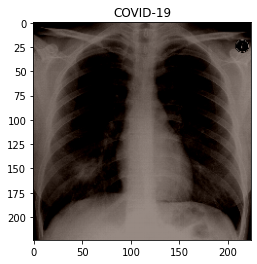

In [15]:
plt.imshow(X[10])
plt.title('COVID-19')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


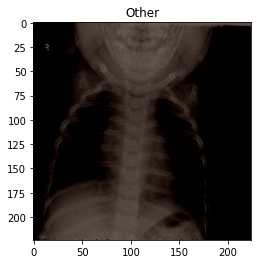

In [16]:
plt.imshow(X[-10])
plt.title('Other')
plt.show()

In [17]:
LOGGER.info('Full data shape: %s', X.shape)


Full data shape: (688, 224, 224, 3)


In [18]:
LOGGER.info('Splitting data into training, validation, and testing set...')
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, 
                                                              stratify=y,
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                              stratify=y_train_full,
                                                              test_size=0.3,
                                                              random_state=42)

Splitting data into training, validation, and testing set...


# Model 1.Compile.Train.Results.Predict

In [19]:
LOGGER.info('Building CNN 1 model...')
base_model = keras.applications.vgg19.VGG19(weights='imagenet',
                                                 include_top=False,
                                                  input_shape=(224, 224, 3))

avg = keras.layers.AveragePooling2D(pool_size=(4, 4))(base_model.output)
flatten = keras.layers.Flatten()(avg)
norm = keras.layers.BatchNormalization()(flatten)
dense = keras.layers.Dense(64, activation=keras.activations.relu)(norm)
dropout = keras.layers.Dropout(0.5)(dense)
output = keras.layers.Dense(1, activation=keras.activations.sigmoid)(dropout)
model = keras.Model(inputs=base_model.input, outputs=output)



Building CNN model...
80142336/80134624 [==============================] - 1s 0us/step


In [34]:
for layer in base_model.layers:
    layer.trainable = False

LOGGER.info('Compiling model...')
model.compile(loss=keras.losses.binary_crossentropy, 
               optimizer=keras.optimizers.Adam(lr=0.0001, decay=0.0001 / 20),
              metrics=['accuracy'])


LOGGER.info('Training top layers of model...')
history = model.fit(X_train, y_train, batch_size=8, epochs=30, validation_data=(X_val, y_val))

Compiling model...
Training top layers of model...
Epoch 1/30
49/49 [==============================] - 4s 82ms/step - loss: 0.3378 - accuracy: 0.8442 - val_loss: 0.3486 - val_accuracy: 0.8182
Epoch 2/30
49/49 [==============================] - 4s 78ms/step - loss: 0.3331 - accuracy: 0.8260 - val_loss: 0.3472 - val_accuracy: 0.8121
Epoch 3/30
49/49 [==============================] - 4s 78ms/step - loss: 0.3285 - accuracy: 0.8442 - val_loss: 0.3469 - val_accuracy: 0.8061
Epoch 4/30
49/49 [==============================] - 4s 79ms/step - loss: 0.3107 - accuracy: 0.8494 - val_loss: 0.3499 - val_accuracy: 0.8121
Epoch 5/30
49/49 [==============================] - 4s 79ms/step - loss: 0.3253 - accuracy: 0.8571 - val_loss: 0.3467 - val_accuracy: 0.8303
Epoch 6/30
49/49 [==============================] - 4s 79ms/step - loss: 0.3329 - accuracy: 0.8338 - val_loss: 0.3418 - val_accuracy: 0.8242
Epoch 7/30
49/49 [==============================] - 4s 79ms/step - loss: 0.2652 - accuracy: 0.8857 - va

In [35]:
import random
import cv2 

try:
    from google.colab.patches import cv2_imshow
except Exception:
    def cv2_imshow(mat):
        return cv2.imshow('img', mat)

def url_to_image(url):
    from skimage import io
    return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

    
def convertData(image):
    img = image.astype('float32')
    img /= 255
    c = np.zeros(224*224*3).reshape((1,224,224,3))
    c[0] = img
    return c

_labels = np.array([
  'PosCovid-19', # class 0
  'NegCovid-19'])# class 1

In [36]:
def CasePrediction(url):
  img = url_to_image(url)
  img = resized = cv2.resize(img, (224,224)) 

  plt.figure(figsize=(16,16))
  data = convertData(img)
  plt.imshow(img)
  ret = model.predict(data, batch_size=8) 
  bestnum = 0.0
  bestclass = 0

  if  ret[0] < 0.5:
      bestclass = 0
  else :
      bestclass = 1



  plt.title(_labels[bestclass])
                                                    
  plt.show()

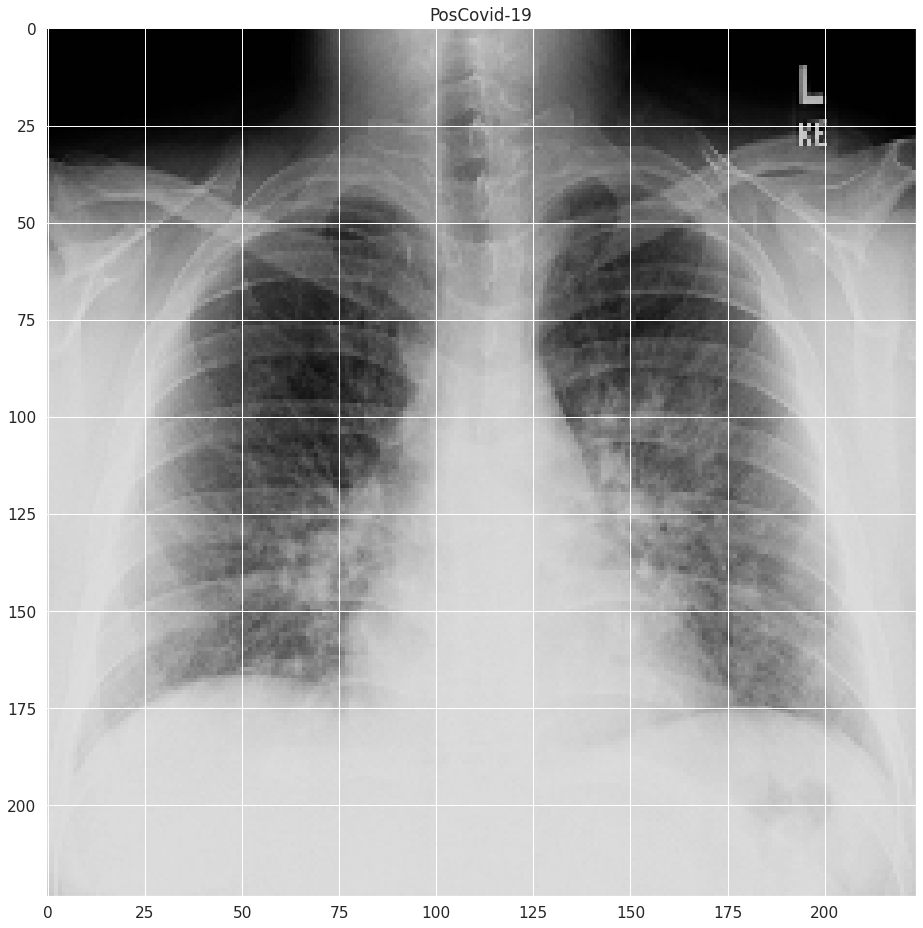

In [51]:
urlp = 'https://github.com/ieee8023/covid-chestxray-dataset/blob/master/images/000001-1.jpg?raw=true'
CasePrediction(urlp)


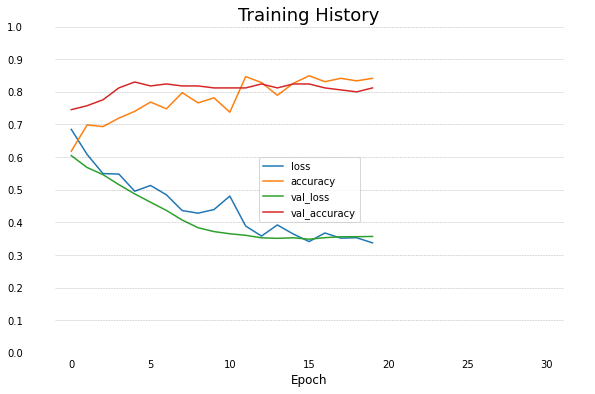

In [22]:
fig, ax = plt.subplots(figsize=[10, 6])

plt_data = pd.DataFrame(history.history)

plt.plot(plt_data)
plt.legend(labels=plt_data.columns, fontsize=10)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  

plt.xlabel('Epoch',fontsize=12)
plt.yticks(np.array(range(0, 11, 1)) / 10)
plt.xticks(fontsize=10)

for y in np.array(range(0, 11, 1)) / 10:    
    plt.plot([-1,31], [y] * 2, "--", lw=0.5, color="black", alpha=0.3)  

plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)

plt.title('Training History', fontsize=18)
plt.gca().set_ylim(0,1)
plt.show()

In [23]:
loss, acc = model.evaluate(X_test, y_test)
print(f'loss: {loss}')
print(f'accuracy: {acc}')

5/5 [==============================] - 1s 228ms/step - loss: 0.3049 - accuracy: 0.8333
loss: 0.30486106872558594
accuracy: 0.8333333134651184


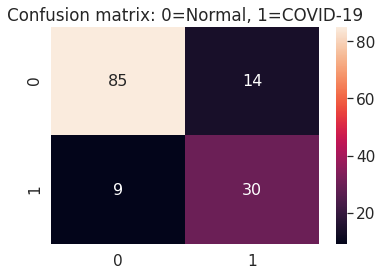

In [24]:
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix

predictions = model.predict(X_test) > 0.5
conf_mx = confusion_matrix(y_test, predictions)

# plot confusion matrix
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mx, annot=True, annot_kws={"size": 16}) # font size
plt.title('Confusion matrix: 0=Normal, 1=COVID-19')
plt.show()

# Model 2.Compile.Train.Results.Predict

In [74]:

model2 = Sequential()

model2.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten()) 

model2.add(Dense(64))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))


INIT_LR = 1e-3

opt = Adam(lr=INIT_LR, decay=INIT_LR / 20)
model2.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

history1 = model2.fit_generator(
	trainAug.flow(X_train, y_train, batch_size=8),
	validation_data=(X_val, y_val),
	validation_steps=len(X_test),
	epochs=20)


Epoch 1/20
49/49 [==============================] - 6s 121ms/step - loss: 0.9327 - accuracy: 0.7532 - val_loss: 0.4482 - val_accuracy: 0.7212
Epoch 2/20
49/49 [==============================] - 5s 105ms/step - loss: 0.4222 - accuracy: 0.7922
Epoch 3/20
49/49 [==============================] - 5s 103ms/step - loss: 0.3921 - accuracy: 0.8156
Epoch 4/20
49/49 [==============================] - 5s 105ms/step - loss: 0.3819 - accuracy: 0.8078
Epoch 5/20
49/49 [==============================] - 5s 105ms/step - loss: 0.3725 - accuracy: 0.8182
Epoch 6/20
49/49 [==============================] - 5s 104ms/step - loss: 0.4103 - accuracy: 0.8130
Epoch 7/20
49/49 [==============================] - 5s 105ms/step - loss: 0.3295 - accuracy: 0.8260
Epoch 8/20
49/49 [==============================] - 5s 105ms/step - loss: 0.3499 - accuracy: 0.8104
Epoch 9/20
49/49 [==============================] - 5s 105ms/step - loss: 0.3192 - accuracy: 0.8571
Epoch 10/20
49/49 [==============================] - 5s 10

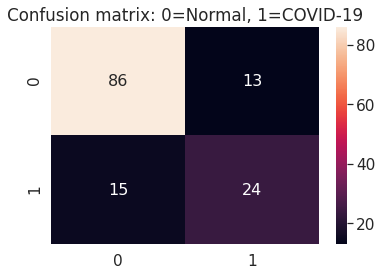

In [75]:
predictions = model2.predict(X_test) > 0.5
conf_mx = confusion_matrix(y_test, predictions)

# plot confusion matrix
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mx, annot=True, annot_kws={"size": 16}) # font size
plt.title('Confusion matrix: 0=Normal, 1=COVID-19')
plt.show()

# Conclusion
Predicting the diagnosis of COVID-19 from x-scans was quite feasible.
If we develop this direction, then it is quite possible to achieve good results.